In [2]:
%matplotlib inline

import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.multiprocessing as mp
import torch.nn as nn
from torch.nn.modules.conv import _ConvNd as ConvBase, _BatchNorm as BatchNormBase
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data as tdata
import torchvision.datasets as dsets
import torchvision.transforms as tfs
import torchvision.utils as tvutils

plt.rcParams['figure.figsize'] = (12, 9)  # Larger plots by default

# Parameters

In [3]:
# Paths are written in UNIX-like notation!
# So write `C:\Users\user\GANerator` as `C:/Users/user/GANerator` or `~/GANerator`.

# Only parameters in the 'Data and Models' section will be saved and loaded!

params = {
    # Experiment specific
    # ===================
    'exp_name':    None,  # File names for this experiment. If `None` or `''`, `append_time` is always `True`.
    'append_time': True,  # Append the current time to the file names (to prevent overwriting).
    'load_dir':    '.',  # Directory to load saved files from. If `save_dir` is `None`, this also acts as `save_dir`.
    'save_dir':    '.',  # Directory to save to. If `None`, use the value of `load_dir`.
    
    # Load the models and parameters from this experiment (previous `exp_name`).
    # Also insert the optionally appended time (WIP: if this value is otherwise ambiguous).
    # Set the parameters `models_file` or `params_file` below to use file names.
    # If set to `True`, use `exp_name`. If `False` or `None`, do not load.
    'load_exp':          False,
    # Load parameters from this path. Set to `False` to not load. Priority over `load_exp`.
    # Set to `True` to ignore this so it does not override `load_exp`.
    'params_file':       True,
    # Load models from this path. Set to `False` to not load. Priority over `load_exp`.
    # Set to `True` to ignore this so it does not override `load_exp`.
    'models_file':       True,
    'load_weights_only': False,  # Load only the models' weights. To continue training, set this to `False`.
    
    'save_params':       False,  # Save the parameters in the 'Data and Models' section to a file.
    'save_weights_only': False,  # Save only the models' weights. To continue training later, set this to `False`.
    'checkpoint_period': 100,  # After how many epochs to save a model checkpoint. Set to `0` to only save when finished.
    
    
    # Data and Models
    # ===============
    # Only parameters in this section will be saved and updated when loading.
    
    # Path to the root folder of the data set. This value is only loaded if set to `None`!
    'dataset_root':  '~/celeba',
    # Set this to the torchvision.datasets class (module `dsets`).
    # This value is only loaded if set to `None`!
    'dataset_class': dsets.ImageFolder,
    'epochs':        5,  # Number of training epochs.
    'batch_size':    128,  # Size of each training batch. Strongly depends on other parameters.
    'img_channels':  3,  # Number of channels in the input images. Normally 3 for RGB and 1 for grayscale.
    'img_shape':     64,  # Shape of the output images (excluding channel dimension). Can be an integer to get squares.
    'resize':        True,  # If `True`, resize images; if `False`, crop (to the center).
    
    'data_mean':     0.0,  # Data is normalized to this mean.
    'data_std':      1.0,  # Data is normalized to this standard deviation.
    'float_dtype':   torch.float16,  # Float precision.
    'g_input':       128,  # Size of the generator's random input vectors (`z` vector).
    
    'virtual_batch_norm': False,  # Use virtual batch normalization.
    
    # If a tuple in this paragraph has fewer activations than the net has layers,
    # the first value in the tuple will be repeated throughout the net.
    #
    # For example, to have a net with hidden layer `LeakyReLU` actiations but
    # `Tanh` output activation, the tuple should be:
    #     (nn.LeakyReLU(inplace=True), nn.Tanh())
    'd_activations': (
        # ...
        nn.LeakyReLU(0.2, inplace=True),
        nn.Sigmoid(),
    ),
    'g_activations': (
        # ...
        nn.LeakyReLU(0.2, inplace=True),
        nn.Tanh(),
    ),

    # Values in this paragraph can be either a single value (e.g. an `int`) or a 2-`tuple` of the same type.
    # If a single value, that value will be applied to both the discriminator and generator network.
    # If a 2-`tuple`, the first value will be applied to the discriminator, the second to the generator.
    'features':    64,  # Relative size of the network's internal features.
    'optimizer':   ('SGD', 'Adam'),  # Optimizer class. Case sensitive.
    'lr':          0.1,  # Optimizer learning rate. (Second optimizer argument, so not necessarily learning rate.)
    'optim_param': 0.5,  # Third optimizer argument. (For example, `betas` for `Adam` or `momentum` for `SGD`.)
    # Any further optimizer keyword arguments as a dictionary.
    'optim_args':  {},
    
    
    # Hardware and Multiprocessing
    # ============================
    'num_workers':    4,  # Amount of worker threads to create on the CPU. Set to `0` to use CPU count.
    'num_gpus':       0,  # Amount of GPUs to use. `None` to use all available ones. Set to `0` to run on CPU only.
    'cuda_device_id': 0,  # ID of CUDA device. In most cases, this should be left at `0`.

    
    # Reproducibility
    # ===============
    'seed':                   0,  # Random seed if `None`.
    'ensure_reproducibility': False  # If using cuDNN: Set to `True` to ensure reproducibility in favor of performance.
}

In [6]:
# Process parameters


# Parameters that we do *not* want to load.
# We list these instead of the model parameters as those should be easier to extend.
static_params = [
        'exp_name',
        'append_time',
        'load_dir',
        'save_dir',
    
        'load_exp',
        'params_file',
        'models_file',
        'load_weights_only',
    
        'save_params',
        'save_weights_only',
        'checkpoint_period',
    
        'num_workers',
        'num_gpus',
        'cuda_device_id',
    
        'seed',
        'ensure_reproducibility'
]


# Experiment name

append_time = params['append_time']
exp_name    = params['exp_name']
if not exp_name or append_time:
    if exp_name is not str:
        exp_name = ''
    exp_name = ''.join((exp_name, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))


# Load parameters

load_dir = params['load_dir']
save_dir = params['save_dir']
if save_dir is None:
    save_dir = load_dir
    
load_exp = params['load_exp']

params_file = params['params_file']
load_params = params_file and (load_exp or type(params_file) is str)

dataset_root  = params['dataset_root']
dataset_class = params['dataset_class']

# Check whether these parameters are `None`.
# If yes, check that parameters loading is enabled. Otherwise do not update them.
if dataset_root is None:
    assert load_params, '`dataset_root` cannot be `None` if not loading parameters.'
else:
    static_params.append('dataset_root')
if dataset_class is None:
    assert load_params, '`dataset_class` cannot be `None` if not loading parameters.'
else:
    static_params.append('dataset_class')


if params_file and (load_exp or type(params_file) is str):
    if type(params_file) is str:
        params_path = Path(params_file)
    elif type(load_exp) is bool:  # 
        params_path = Path('{}/params_{}.pt'.format(load_dir, exp_name))
    else:
        params_path = Path('{}/params_{}.pt'.format(load_dir, load_exp))

    params_path = params_path.expanduser()
    upd_params = torch.load(params_path)
    params.update(upd_params)
    del upd_params
elif params_file == '':
    print("`params_file` is an empty string (`''`). Parameters were not loaded. "
          'Set to `False` to suppress this warning or to `True` to let `load_exp` handle loading.')


# Hardware and multiprocessing

num_gpus       = params['num_gpus']
cuda_device_id = params['cuda_device_id']
if num_gpus is None:
    num_gpus = torch.cuda.device_count()
    print('Using {} GPUs.'.format(num_gpus))
use_gpus = num_gpus > 0
multiple_gpus = num_gpus > 1
if use_gpus:
    assert torch.cuda.is_available(), 'CUDA is not available. ' \
            'Check what is wrong or set `num_gpus` to `0` to run on CPU.'  # Never check for this again
    device = torch.device('cuda:' + cuda_device_id)
else:
    device = torch.device('cpu')
    
num_workers = params['num_workers']
if not num_workers:
    num_workers = mp.cpu_count()


# Load model

models_file = params['models_file']
models_cp = None
if models_file and (load_exp or type(models_file) is str):
    if type(models_file) is str:
        models_path = Path(models_file)
    elif type(load_exp) is bool:
        models_path = Path('{}/models_{}.pt'.format(load_path, exp_name))
    else:
        models_path = Path('{}/models_{}.pt'.format(load_path, load_exp))
    models_path = models_path.expanduser()
    models_cp = torch.load(models_path, map_location=device)
elif models_file == '':
    print("`models_file` is an empty string (`''`). Models were not loaded. "
          'Set to `False` to suppress this warning or to `True` to let `load_exp` handle loading.')


# Reproducibility

seed = params['seed']
if seed is None:
    seed = np.random.randint(10000)
print('Seed: {}.'.format(seed))
np.random.seed(seed)
torch.manual_seed(seed)

ensure_reproducibility = params['ensure_reproducibility']
torch.backends.cudnn.deterministic = ensure_reproducibility
if ensure_reproducibility:
    torch.backends.cudnn.benchmark = False  # This is the default but do it anyway

    
# Checkpoint period

checkpoint_period = params['checkpoint_period']
checkpoint_epoch = checkpoint_period


# Dataset root

dataset_root = Path(dataset_root)
dataset_root = dataset_root.expanduser()


# Parameters we do not need to process

epochs       = params['epochs']
batch_size   = params['batch_size']
img_channels = params['img_channels']
resize       = params['resize']

data_mean    = params['data_mean']
data_std     = params['data_std']
float_dtype  = params['float_dtype']
g_input      = params['g_input']

virtual_batch_norm = params['virtual_batch_norm']

d_activations = params['d_activations']
g_activations = params['g_activations']


# Single or tuple parameters

def param_as_ntuple(key, n=2):
    val = params[key]
    if type(val) in (tuple, list):
        assert 0 < len(val) <= n, 'Tuples should have length {} (`{}` is `{}`).'.format(n, key, val)
        if len(val) < n:
            if len(val) > 1:
                print('`{}` is `{}`. Length is less than {}; '.format(key, val, n)
                      'last entry has been repeated to fit length.')
            return val + (val[-1],) * (n - len(val))
        else:
            return val
    return (val,) * n


img_shape = param_as_ntuple('img_shape')

d_features,  g_features  = param_as_ntuple('features')
d_optimizer, g_optimizer = param_as_ntuple('optimizer')
d_lr,        g_lr        = param_as_ntuple('lr')
d_beta1,     g_beta1     = param_as_ntuple('beta1')


save_models_path = Path('{}/models_{}.pt'.format(save_dir, exp_name))
save_models_path = save_models_path.expanduser()


# Save parameters

save_params = params['save_params']
if save_params:
    # We save even if we load to associate the parameters with the experiment
    save_params_path = Path('{}/params_{}.pt'.format(save_dir, exp_name))
    save_params_path = save_params_path.expanduser()
    save_params_ = params.copy()
    for key in static_params:
        del save_params_[key]
    torch.save(save_params_, save_params_path)
    del save_params_

Seed: 0.


In [7]:
# Prepare dataset

tfs_list = [
    tfs.Resize(img_shape),
    tfs.ToTensor(),
    tfs.Normalize((data_mean,) * img_channels, (data_std,) * img_channels)
]
if not resize:
    tfs_list[0] = tfs.CenterCrop(img_shape)
transform = tfs.Compose(tfs_list)
dataset = dataset_class(dataset_root, transform=transform)

dataloader = tdata.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

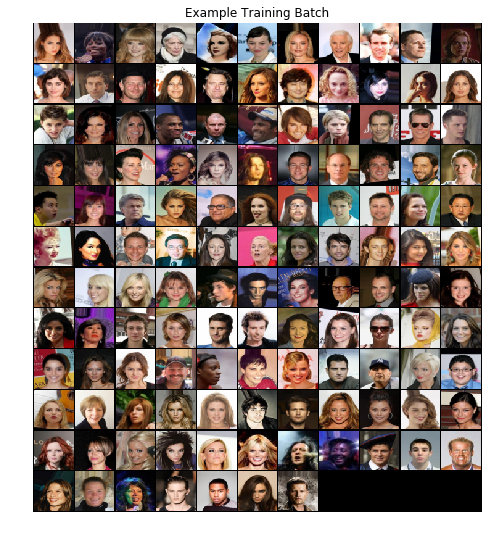

In [10]:
# Show an example batch of training images

show_example = True

if show_example or virtual_batch_norm:
    example_batch = next(iter(dataloader))
    if show_example:
        example_batch_size = batch_size  # Modify this value if the images are hard to see
        example_batch_cols = int(np.sqrt(example_batch_size))
        plt.figure()
        plt.axis('off')
        plt.title('Example Training Batch')
        plt.imshow(np.transpose(tvutils.make_grid(example_batch[0].to(device)[:example_batch_size],
                                                  nrow=example_batch_cols, padding=2, normalize=True).cpu(),
                                (1, 2, 0)))

In [ ]:
# Define models and initialize


# Discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


def init_weights(module):
    if isinstance(module, ConvBase):
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif isinstance(module, BatchNormBase):
        nn.init.normal_(module.weight.data, 1.0, 0.02)